In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

### Load data

In [3]:
TrainFile = 'train100k_2.csv'
TestFile = 'test100k_2.csv'

In [4]:
train_f = pd.read_csv(TrainFile)
test_f = pd.read_csv(TestFile)

In [5]:
X_train_f = train_f.drop(columns = 'HasDetections')
Y_train_f = train_f['HasDetections']
X_test_f = test_f.drop(columns = 'HasDetections')
Y_test_f = test_f['HasDetections']

In [6]:
# how balanced is our data?
test = pd.DataFrame(Y_test_f)
frac = len(test[test['HasDetections']==1])/len(test)
frac

0.49981

### Logit

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create the regressor: reg
reg = LogisticRegression()


# Fit the regressor to the training data
reg.fit(X_train_f, Y_train_f)

# Predict on the test data: y_pred
y_pred_prob = reg.predict_proba(X_test_f)[:,1]

C:\Users\Wendy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.5573173988766325


In [40]:
y_pred_label = reg.predict(X_test_f)

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [11]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

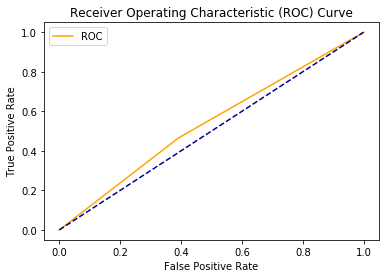

In [44]:
fpr, tpr, thresholds = roc_curve(Y_test_f, y_pred_label)
plot_roc_curve(fpr, tpr) 

In [51]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(reg.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(reg.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, y_pred_prob)))

Train Accuracy:0.53534
Test Accuracy:0.53689
AUC: 0.5573173988766325


### KNN 

In [49]:
### First try K=6
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the data
knn.fit(X_train_f,Y_train_f)

#Predict the result for testing set
pred_labels_knn = knn.predict(X_test_f)

0.52147


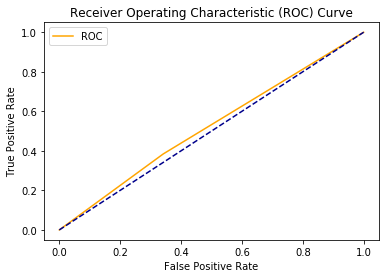

In [52]:
fpr, tpr, thresholds = roc_curve(Y_test_f, pred_labels_knn)
plot_roc_curve(fpr, tpr) 

In [53]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(knn.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(knn.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, pred_labels_knn)))

Train Accuracy:0.67067
Test Accuracy:0.52147
AUC: 0.5214179278927488


In [38]:
# Avoid overfitting
## Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_auc = np.empty(len(neighbors))
testing_auc = np.empty(len(neighbors))

## Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train_f,Y_train_f)
    
    #Predict the result for training set
    pred_labels_knn_train = knn.predict(X_train_f)
    
    #Predict the result for testing set
    pred_labels_knn_test = knn.predict(X_test_f)
    
    #Compute auc on the training set
    train_auc[i] = roc_auc_score(Y_train_f, pred_labels_knn_train)
    
    #Compute auc on the testing set
    testing_auc[i] = roc_auc_score(Y_test_f, pred_labels_knn_test)

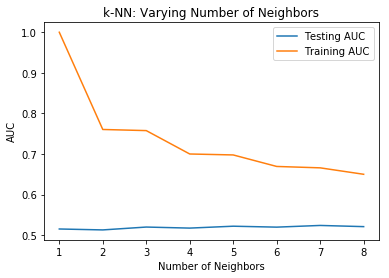

In [39]:
## Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, testing_auc, label = 'Testing AUC')
plt.plot(neighbors, train_auc, label = 'Training AUC')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('AUC')
plt.show()

In [48]:
np.max(testing_auc)

0.5240144190676821

In [49]:
testing_auc
# 7 NN best

array([0.51527143, 0.51299845, 0.52005241, 0.51747494, 0.52213326,
       0.51984875, 0.52401442, 0.52109777])

### GradientBoosting

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train_f, Y_train_f)

#Predict the result for testing set
pred_labels_XGBoost = clf.predict(X_test_f)

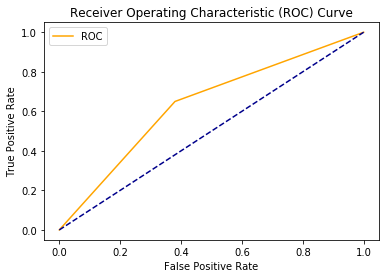

In [19]:
fpr, tpr, thresholds = roc_curve(Y_test_f, pred_labels_XGBoost)
plot_roc_curve(fpr, tpr) 

In [20]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(clf.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(clf.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, pred_labels_XGBoost)))

Train Accuracy:0.64126
Test Accuracy:0.63483
AUC: 0.6348356966702746


In [31]:
##Grid Search for the Best Parameters
from sklearn.model_selection import GridSearchCV
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train_f,Y_train_f)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
gsearch2.best_params_

{'max_depth': 11, 'min_samples_split': 1000}

In [33]:
clf_best = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10\
                                      , max_depth=11,min_samples_split = 1000)
clf_best.fit(X_train_f, Y_train_f)

#Predict the result for testing set
pred_labels_bestXGBoost = clf_best.predict(X_test_f)

In [34]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(clf_best.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(clf_best.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, pred_labels_bestXGBoost)))

Train Accuracy:0.67264
Test Accuracy:0.64056
AUC: 0.6405586028966622


### AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier
adclf = AdaBoostClassifier(n_estimators=100,learning_rate=1)
adclf.fit(X_train_f,Y_train_f)
#Predict the result for testing set
pred_labels_ada = adclf.predict(X_test_f)

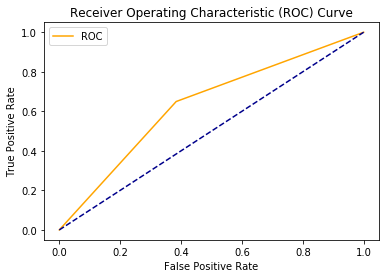

In [55]:
fpr, tpr, thresholds = roc_curve(Y_test_f, pred_labels_ada)
plot_roc_curve(fpr, tpr) 

In [56]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(adclf.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(adclf.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, pred_labels_ada)))

Train Accuracy:0.64007
Test Accuracy:0.63273
AUC: 0.6327363879671345


### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf_100 = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)

# Train the model on training data
rf_100.fit(X_train_f,Y_train_f)

#Predict the result for testing set
pred_labels_rf_100 = rf_100.predict(X_test_f)

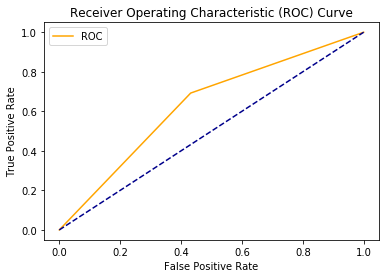

In [15]:
fpr, tpr, thresholds = roc_curve(Y_test_f, pred_labels_rf_100)
plot_roc_curve(fpr, tpr)

In [16]:
###Calculate Acc in train/test + AUC
print("Train Accuracy:{}".format(rf_100.score(X_train_f, Y_train_f)))
print("Test Accuracy:{}".format(rf_100.score(X_test_f, Y_test_f)))
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(Y_test_f, pred_labels_rf_100)))

Train Accuracy:0.64273
Test Accuracy:0.6303
AUC: 0.6303235598187221


In [17]:
## Setup arrays to store train and test accuracies
num_tree = [100,200,500,1000]
train_auc = np.empty(len(num_tree))
testing_auc = np.empty(len(num_tree))

## Loop over different number of trees
for i, k in enumerate(num_tree):
    # Setup a k-NN Classifier with k neighbors: knn
    rf = RandomForestClassifier(n_estimators = k, max_depth = 8, random_state = 42)

    # Fit the classifier to the training data
    rf.fit(X_train_f,Y_train_f)
    
    #Predict the result for training set
    pred_labels_rf_train = rf.predict(X_train_f)
    
    #Predict the result for testing set
    pred_labels_rf_test = rf.predict(X_test_f)
    
    #Compute auc on the training set
    train_auc[i] = roc_auc_score(Y_train_f, pred_labels_rf_train)
    
    #Compute auc on the testing set
    testing_auc[i] = roc_auc_score(Y_test_f, pred_labels_rf_test)

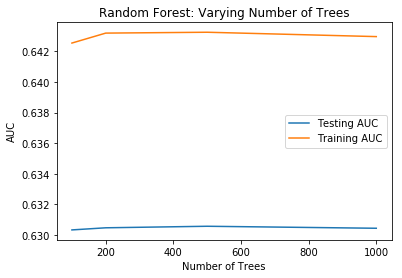

In [18]:
## Generate plot
plt.title('Random Forest: Varying Number of Trees')
plt.plot(num_tree, testing_auc, label = 'Testing AUC')
plt.plot(num_tree, train_auc, label = 'Training AUC')
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.show()